# Titanic Survival Classifier

## Imports

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Datasets

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Functions

In [8]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins'

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins'

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins'

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [9]:
def process_dataframe(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    return df

In [38]:
def plot_horizontally(df, column, column2, title, kind="barh"):
    df.pivot_table(index=[column],values=[column2]).reset_index().plot(
        x=column, 
        y=column2, 
        kind=kind,
        figsize=(20,10),
        title=title)   

## Preprocessing the data

In [10]:
%time
train = process_dataframe(train)

Wall time: 0 ns


In [12]:
%time
test = process_dataframe(test)

Wall time: 0 ns


## EDA

We are going to examine the two columns that contain information about the family members each passenger has onboard: **SibSp and Parch**.

Text(0.5, 1.0, 'Parch')

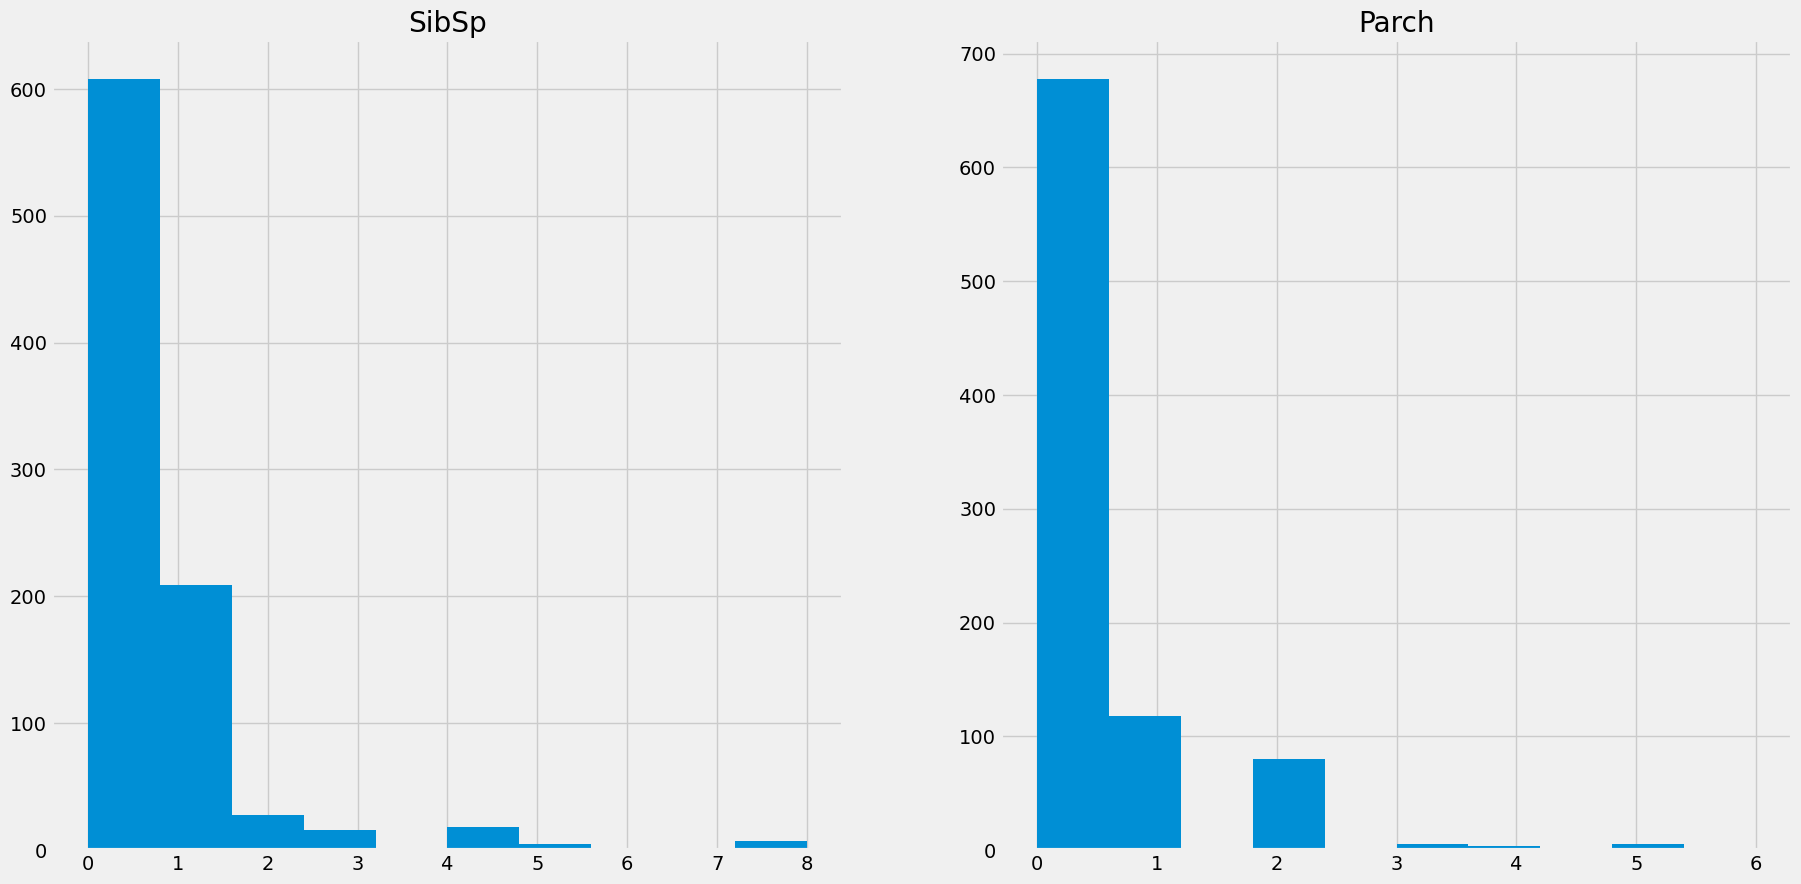

In [20]:
%matplotlib inline

fig,axes = plt.subplots(1,2, figsize=(20,10))
train['SibSp'].hist(ax=axes[0])
axes[0].set_title('SibSp')
train['Parch'].hist(ax=axes[1])
axes[1].set_title('Parch')

These columns contain an integer value indicating the number of relatives the passenger has onboard. **SibSp** contains the number of siblings and spouses, and **Parch** contains the number of parents and children.

We'll take a look at survival rate for different values of the columns:

In [22]:
train.pivot_table(index=['SibSp'],values=['Survived'])

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [24]:
train.pivot_table(index=['SibSp'],values=['Survived']).reset_index()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


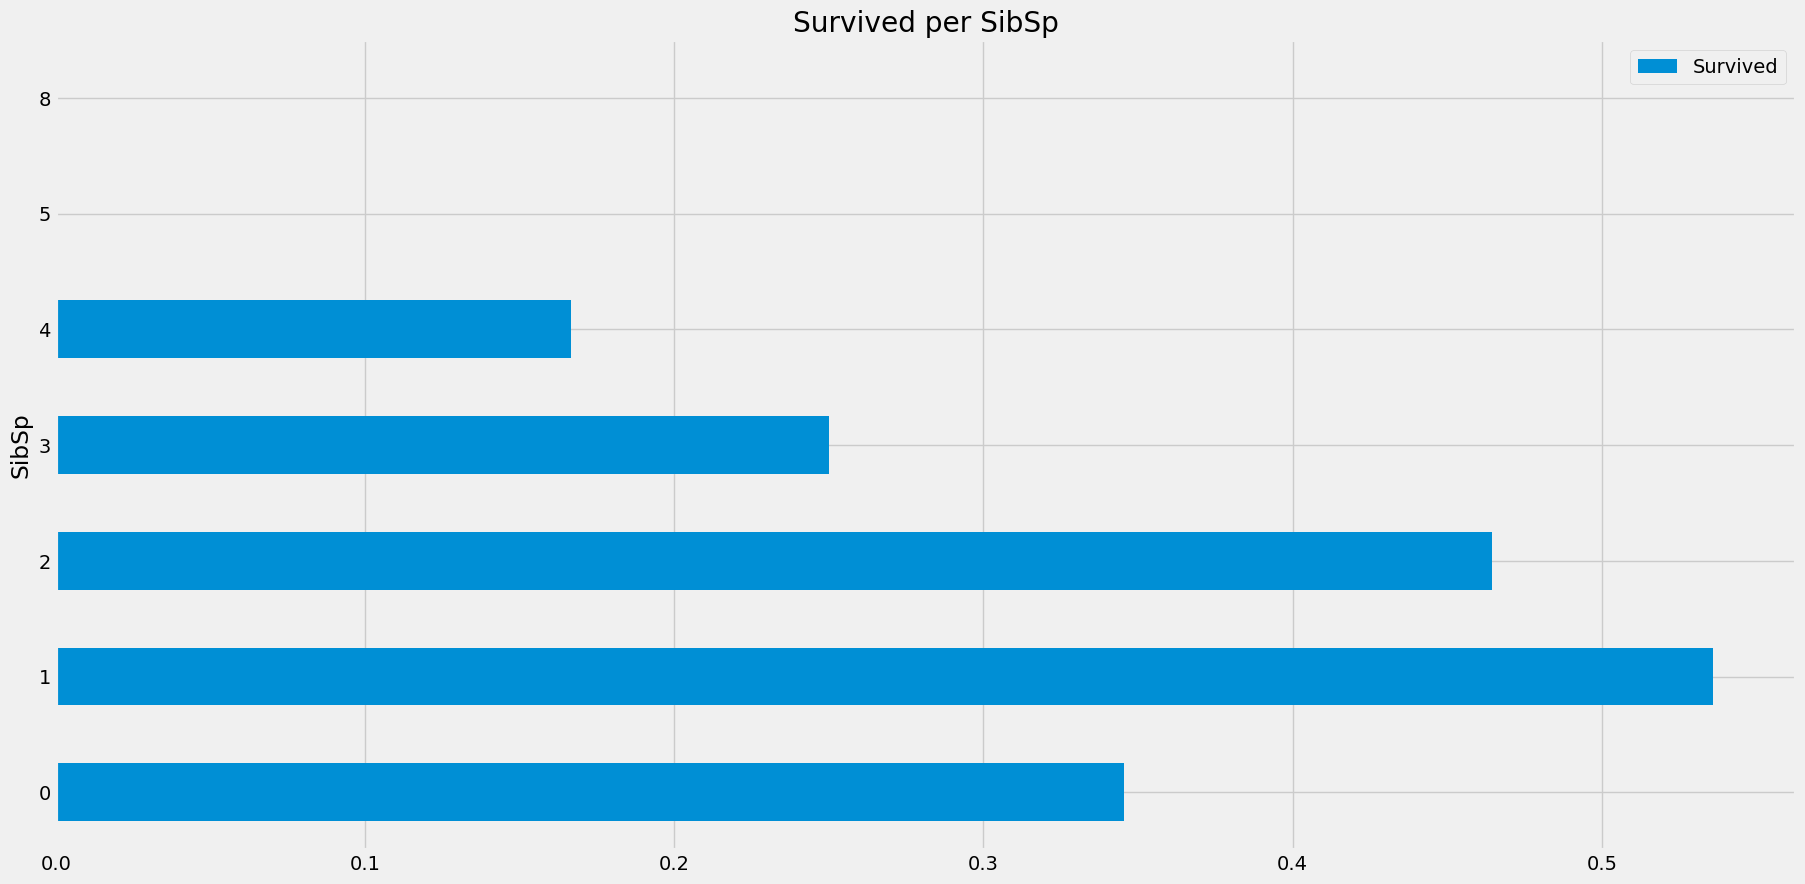

In [39]:
plot_horizontally(train, "SibSp", "Survived", "Survived per SibSp", kind="barh")

In [40]:
 train.pivot_table(index=['Parch'],values=['Survived'])

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


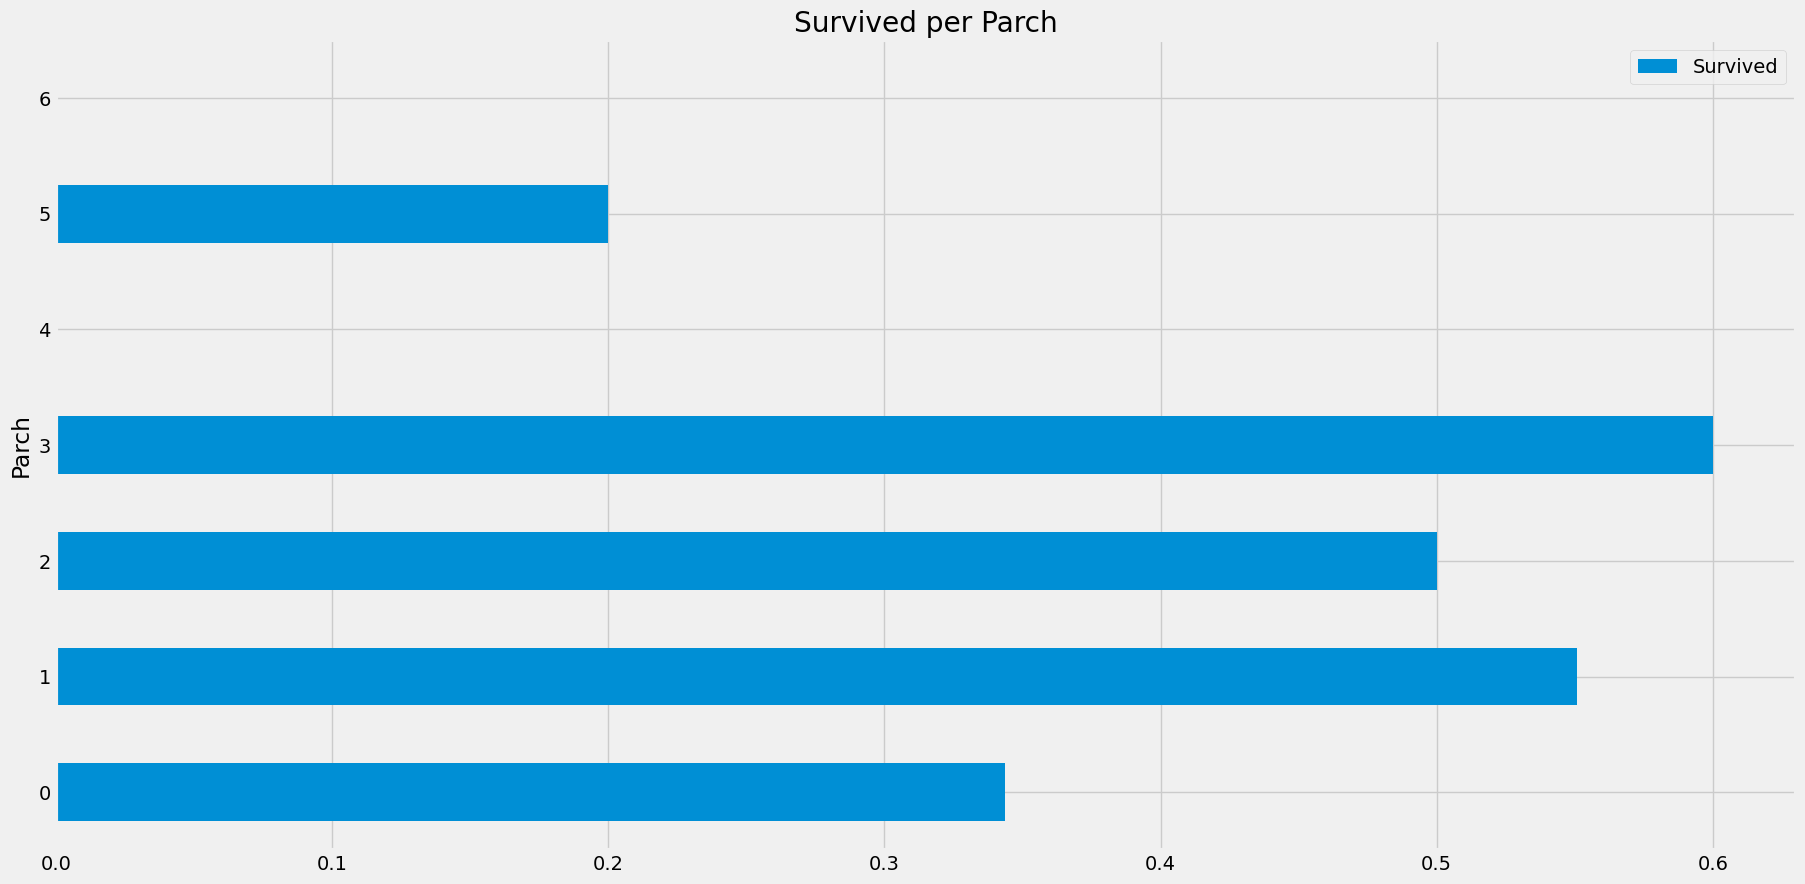

In [41]:
plot_horizontally(train, "Parch", "Survived", "Survived per Parch", kind="barh")

We will create just one column for both columns:

In [43]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore

,SibSp,Parch,Survived
0,1,0,0
1,1,0,1
2,0,0,1
3,1,0,1
4,0,0,0
...,...,...,...
886,0,0,0
887,0,0,1
888,1,2,0
889,0,0,1


In [44]:
explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)

In [ ]:
pivot = explore.pivot_table(index='familysize',values="Survived")

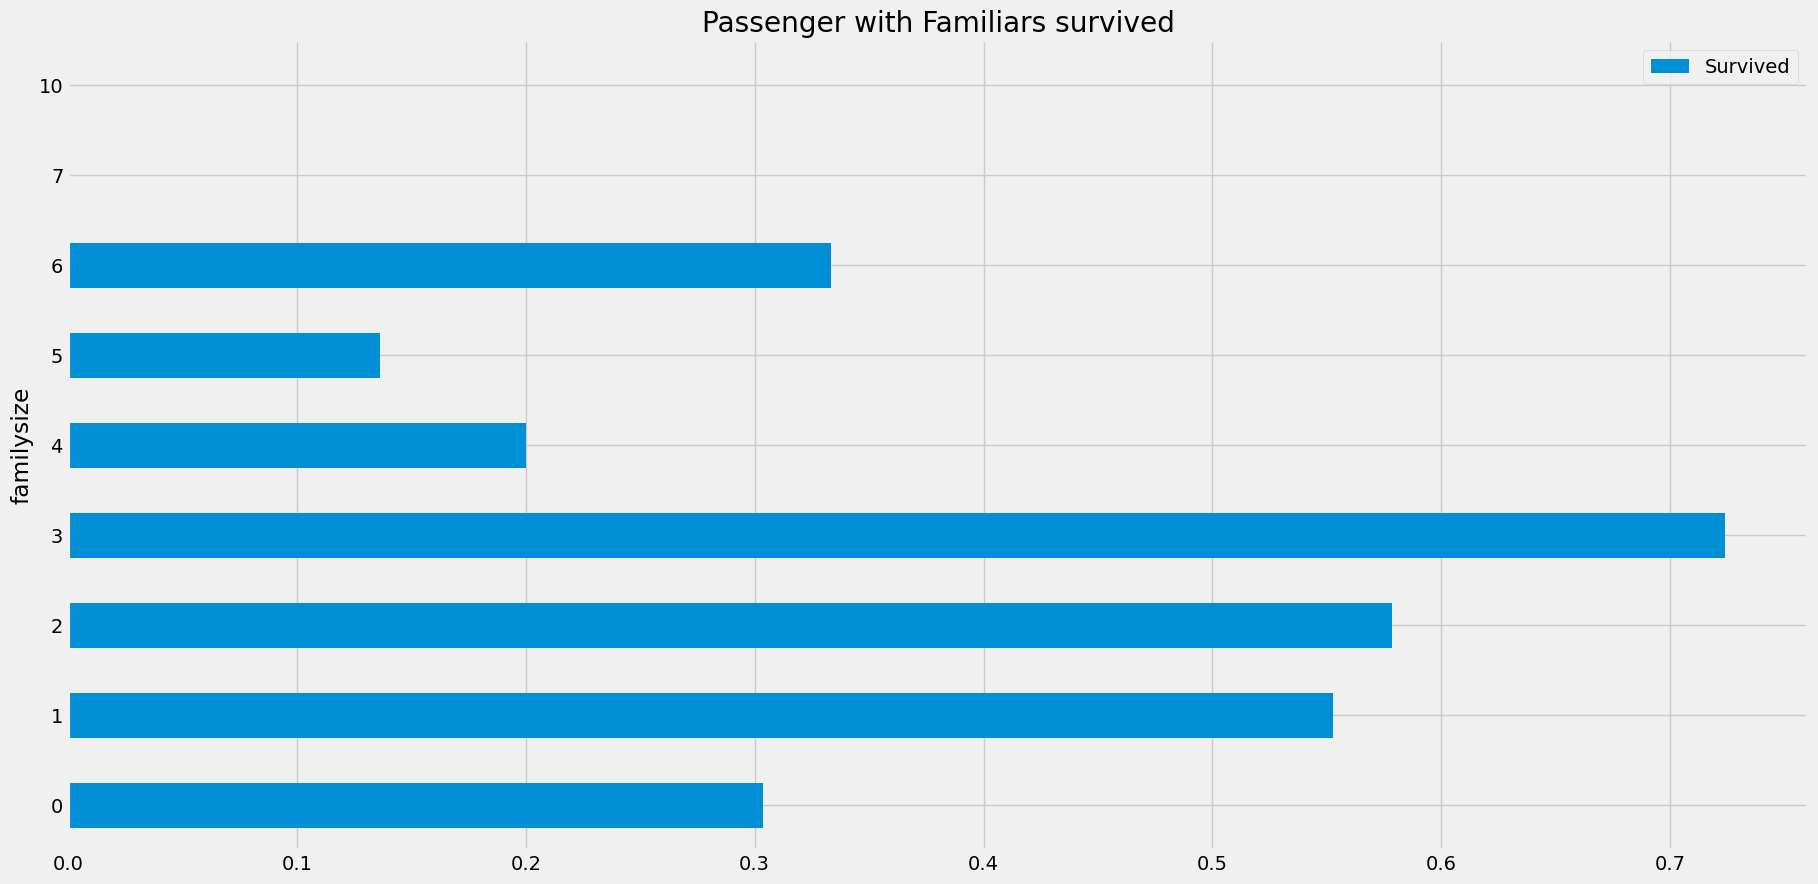

In [45]:
plot_horizontally(explore, "familysize", "Survived", "Passenger with Familiars survived", kind="barh")

Having a few relatives on board increased a passenger's chance of surivival. Only nearby the **30%** of the passengers who had no family onboard survived.